<a href="https://colab.research.google.com/github/sofieneJ/classification_CES_project_sources/blob/master/consumer_complaints_classification_with_fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [2]:
pip install fasttext

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2385260 sha256=93db1d8df6ea51130a7784952bf4845bb0ce38b8430832d519a066223b66dda2
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext


In [3]:
import numpy as np
import pandas as pd
import fasttext as ft
import gensim

from sklearn.preprocessing import StandardScaler


from time import time
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.externals import joblib

from sklearn.svm import  SVC

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# mounting to google drive

In [24]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"


#@markdown 1- complaints_data_dir is the main dataset dir.
#@markdown under the complaints_data_dir there should be the raw csv file with two columns ['Product', 'Consumer complaint narrative']
complaints_data_dir = root_dir + 'my_colab_storage/consumer_complaints_data/'

#@markdown 2- The dir to train/test split csv files. This director should be under complaints_data_dir
evaluation_data_dir = complaints_data_dir+'train_test_data/'
# tf.gfile.MakeDirs(evaluation_data_dir)

#@markdown 3- ft_model is the path to the fasttext fine-tuned model
ft_model_path = root_dir +'my_colab_storage/CC_fasttext_models/myFastTextModel2_skipgram_100_reduced.bin'
#@markdown 4- trained_classifier_path is the path to the trained classifier
trained_classifier_path = root_dir+'my_colab_storage/CC_fasttext_models/fasttext_svm_classifier.sav'
#@markdown 5- data scaler
data_scaler_path = root_dir+'my_colab_storage/CC_fasttext_models/std_scaler.sav'

train_test_data_dir = complaints_data_dir +'train_test_data/'


Mounted at /content/gdrive


# Data

In [6]:
LABEL_COLUMN = 'Product'
DATA_COLUMN = 'Consumer complaint narrative'
from sklearn.model_selection import train_test_split
# kept_categories = []

def filter_subsample_split_data():
  # label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
  # label_list = []
  raw_data_file = complaints_data_dir +'Consumer_Complaints_light.csv'
  complains_df = pd.read_csv(filepath_or_buffer=raw_data_file, sep=',')
  my_categories = ['Debt collection', 'Mortgage', 'Credit reporting', 'Student loan', 'Credit card', 'Bank account or service', 
  'Checking or savings account', 'Consumer Loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service']

  my_categories = ['Debt collection', 'Mortgage', 'Credit reporting', 'Student loan', 'Credit card']

  complains_df = complains_df.loc[complains_df[LABEL_COLUMN].isin(my_categories)].reset_index(drop=True)
  print ('size after category filter ', complains_df.shape)
  # print (complains_df.head())
  count_cols = [LABEL_COLUMN, 'Count']
  complains_by_group = complains_df.groupby(by=LABEL_COLUMN,axis=0).count().reset_index().rename(columns = {DATA_COLUMN:'Count'})
  # print (type(complains_by_group))
  print (complains_by_group.sort_values(by="Count", ascending =False))


  ########################### Sub-sample the dataset #########################################
  index_reduced = np.arange(0,complains_df.shape[0])
  np.random.shuffle(index_reduced)
  kept_data_ratio = 0.1
  index_reduced = index_reduced[0:int(complains_df.shape[0]*kept_data_ratio)]
  complains_df = complains_df.loc[index_reduced]

  print ('complaints distribution after subsampling')
  count_cols = [LABEL_COLUMN, 'Count']
  complains_by_group = complains_df.groupby(by=LABEL_COLUMN,axis=0).count().reset_index().rename(columns = {DATA_COLUMN:'Count'})
  # print (type(complains_by_group))
  print (complains_by_group.sort_values(by="Count", ascending =False))
  kept_categories =  np.sort(complains_df[LABEL_COLUMN].unique())
  

  ########################### test train split the dataset #########################################
  cats = complains_df[LABEL_COLUMN]
  corpus = complains_df[DATA_COLUMN]
  corpus_train, corpus_test, cat_train, cat_test = train_test_split(corpus, cats, test_size = 0.3, random_state=100)
  
  ########################### Dump train test datasets #######################################
  
  corpus_train.to_csv(path_or_buf= train_test_data_dir+'train_corpus.csv', index = False, header = True)
  corpus_test.to_csv(path_or_buf= train_test_data_dir+'test_corpus.csv', index = False, header = True)
  cat_train.to_csv(path_or_buf= train_test_data_dir+'train_cat.csv', index = False, header = True)
  cat_test.to_csv(path_or_buf= train_test_data_dir+'test_cat.csv', index = False, header = True)
  print (f'train subset size: {corpus_train.shape}')
  print (f'test subset size: {corpus_test.shape}')
  
   ########################### dump test data set to file for evaluation ############################
  test_data_set = pd.concat((cat_test, corpus_test), axis=1)
  test_data_set.to_csv(path_or_buf= train_test_data_dir+'test_data_set.csv',columns=['Product', 'Consumer complaint narrative'],index=False)
  
  return kept_categories
  
kept_categories = filter_subsample_split_data()
print ('kept categories are:',kept_categories )

size after category filter  (212171, 2)
            Product  Count
2   Debt collection  86850
3          Mortgage  53056
1  Credit reporting  31588
4      Student loan  21839
0       Credit card  18838
complaints distribution after subsampling
            Product  Count
2   Debt collection   8678
3          Mortgage   5292
1  Credit reporting   3217
4      Student loan   2149
0       Credit card   1881
train subset size: (14851,)
test subset size: (6366,)
kept categories are: ['Credit card' 'Credit reporting' 'Debt collection' 'Mortgage'
 'Student loan']


In [0]:
max_seq_length = 512
min_seq_length = 5

REFUSED_DOC_TAG = '<<<refused_document>>>'
def simple_preprocess_func (doc):
  seq = gensim.utils.simple_preprocess(gensim.parsing.remove_stopwords(doc), min_len=2, max_len=25)
  if len(seq)<min_seq_length or len(seq)>max_seq_length:
    return REFUSED_DOC_TAG
  else:
    return ' '.join(seq)


In [14]:
def preprocess_data():
 
  subsets = ('train','test')
  dfs = []
  for subset in subsets:
    ############################# corpus preprocessing ######################################
    corpus_path = train_test_data_dir+f'{subset}_corpus.csv'
    corpus_ser = pd.read_csv(filepath_or_buffer=corpus_path, sep=',')[DATA_COLUMN]
    print (f'{subset} corpus size before preprocessing is {corpus_ser.shape}')
    corpus_ser = corpus_ser.apply(lambda txt : simple_preprocess_func(txt))

    valid_index = (corpus_ser != REFUSED_DOC_TAG).tolist()
    corpus_ser = corpus_ser[valid_index].reset_index(drop=True)
    print (f'{subset} corpus size after preprocessing is {corpus_ser.shape}')
    
    ###################################### Some statictics #####################################
    doc_lens = np.array([len(doc.split()) for doc in corpus_ser])
    print (f'{subset} mean length is {np.mean(doc_lens)}')
    print (f'{subset} max length is {np.max(doc_lens)}')

    
    ###################################### Named category conversion ##########################
    cat_path = train_test_data_dir+ f'{subset}_cat.csv'
    cats_ser = pd.read_csv(filepath_or_buffer=cat_path, sep=',')[LABEL_COLUMN]
    class_dico = {i:classe for i,classe in enumerate(np.sort(cats_ser.unique()))}
    print ('classes', class_dico)
    inv_class_dico = {item[1]:item[0] for item in class_dico.items()}
    cats_ser = cats_ser.apply(lambda x : inv_class_dico[x])
    cats_ser = cats_ser[valid_index].reset_index(drop=True)
    #preprocessed_cat_path = f'data\\{subset}_cat_reduced.csv'
    #cats_ser.to_csv(path_or_buf=preprocessed_cat_path, index=False)

    assert(cats_ser.shape[0]==corpus_ser.shape[0])
    
    ###################################### Dump preprocessed training corpus ###################
    if subset=='train':
      corpus_ser.to_csv(train_test_data_dir+'preprocessed_train_corpus.csv', header=False)
    
    ###################################### returning DataFrames ##########################
    data_dic = {DATA_COLUMN: corpus_ser, LABEL_COLUMN:cats_ser}
    subset_df = pd.DataFrame(data_dic)
    dfs.append(subset_df)
  
  label_list = [i for i in np.sort(dfs[0][LABEL_COLUMN].unique())]
  
  return dfs[0], dfs[1], label_list

train_df, test_df, label_list = preprocess_data()
print ('the label list is:', label_list)


train corpus size before preprocessing is (14851,)
train corpus size after preprocessing is (14659,)
train mean length is 93.67814994201514
train max length is 509
classes {0: 'Credit card', 1: 'Credit reporting', 2: 'Debt collection', 3: 'Mortgage', 4: 'Student loan'}
test corpus size before preprocessing is (6366,)
test corpus size after preprocessing is (6275,)
test mean length is 92.8380876494024
test max length is 510
classes {0: 'Credit card', 1: 'Credit reporting', 2: 'Debt collection', 3: 'Mortgage', 4: 'Student loan'}
the label list is: [0, 1, 2, 3, 4]


In [31]:
train_text = train_df[DATA_COLUMN].tolist()
train_label = train_df[LABEL_COLUMN].tolist()
print (f' train text length {len(train_text)}')


test_text = test_df[DATA_COLUMN].tolist()
test_label = test_df[LABEL_COLUMN].tolist()
print (f' test text length {len(test_text)}')

 train text length 14659
 test text length 6270


# Training model

## fine-tune fasttext

In [32]:
    # # # # # # TRAIN THE MODEL # # # # # # 
  preprocessed_train_corpus = train_test_data_dir+ 'preprocessed_train_corpus.csv'
  t0 = time()
  print ('starting training of fasttext model...')
  model = ft.train_unsupervised(input=preprocessed_train_corpus, model='skipgram', verbose=0, dim=100, epoch=10)
  print ('training of fastText done in {}'.format (time() - t0))

  model.save_model(ft_model_path)

starting training of fasttext model...
training of fastText done in 313.9973051548004


## generate documents embeddings

In [33]:

#     model_path = f'model\\myFastTextModel2_skipgram_{dim}_reduced.bin'
#     model = ft2.load_model(model_path)
t0 = time()
X_train = np.vstack([model.get_sentence_vector(doc) for doc in train_text])
X_test = np.vstack([model.get_sentence_vector(doc) for doc in test_text])
print(f'it took {time()- t0} seconds to infer fasttext embeddings')

print (f'subset train shape {X_train.shape}')
print (f'subset test shape {X_test.shape}')

it took 8.650897741317749 seconds to infer fasttext embeddings
subset train shape (14659, 100)
subset test shape (6270, 100)


## scaling data

In [34]:
t0 = time()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f'scaling the data it took {time()- t0} seconds')

joblib.dump(scaler, data_scaler_path) 

scaling the data it took 0.052205562591552734 seconds


['/content/gdrive/My Drive/my_colab_storage/CC_fasttext_models/std_scaler.sav']

## training the classifier

In [35]:
clf = SVC(probability=True)
t0 = time()
clf.fit(X_train, train_label)
print(f'training the model {clf.__class__.__name__} took {time()- t0} seconds')


joblib.dump(clf, trained_classifier_path)

training the model SVC took 85.06654620170593 seconds


['/content/gdrive/My Drive/my_colab_storage/CC_fasttext_models/fasttext_svm_classifier.sav']

## Evaluate classifier

In [36]:
label_pred = clf.predict(X_test)
print (f'{clf.__class__.__name__} with FastText accuracy score {clf.score(X_test, test_label)}')

classification_report_df = classification_report(test_label, label_pred, target_names = kept_categories) 
print (classification_report_df)

SVC with FastText accuracy score 0.8771929824561403
                  precision    recall  f1-score   support

     Credit card       0.83      0.77      0.80       578
Credit reporting       0.80      0.78      0.79       934
 Debt collection       0.87      0.90      0.89      2521
        Mortgage       0.93      0.95      0.94      1581
    Student loan       0.89      0.86      0.87       656

        accuracy                           0.88      6270
       macro avg       0.87      0.85      0.86      6270
    weighted avg       0.88      0.88      0.88      6270



# Model's predictions Analysis

In [26]:

ft_model = ft.load_model(ft_model_path)
scaler = joblib.load(data_scaler_path)
classifier =joblib.load(trained_classifier_path)

cat_dict = {0: 'Credit card', 1: 'Credit reporting', 2: 'Debt collection', 3: 'Mortgage', 4: 'Student loan'}
cats_list = list(cat_dict.values())

test_data_df = pd.read_csv(train_test_data_dir+'test_data_set.csv')



confidence_threshold_span = np.arange(0.5, 0.95, 0.05)
std_dev_threshold = 0.3

unclassified_perc = []
true_confident_classification_perc = []

for confidence_threshold in confidence_threshold_span:
  nb_correct_calssification = 0
  nb_unclassified = 0
  nb_refused_documents = 0
  
  for index , row in test_data_df.iterrows():
    preprocessed_doc = simple_preprocess_func (row['Consumer complaint narrative'])
    if preprocessed_doc != REFUSED_DOC_TAG:
      # get the document embedding
      tf_embeddings = ft_model.get_sentence_vector(preprocessed_doc)
      # scale the embeddings
      tf_embeddings = scaler.transform(tf_embeddings.reshape(1,-1))
      # run classification
      preds = classifier.predict_proba(tf_embeddings.reshape(1,-1))


      proba_dict = dict(zip(cats_list, preds[0]))


      cats, proba_list = list(proba_dict.keys()), list(proba_dict.values())
      if np.max(proba_list) > confidence_threshold :#or np.std(proba_list)>std_dev_threshold:
        if cats[np.argmax(proba_list)] == row['Product']:
          nb_correct_calssification +=1
      else:
        nb_unclassified +=1
    else:
      nb_refused_documents +=1
  
  unclassified_per = ((nb_refused_documents+nb_unclassified)/test_data_df.shape[0])*100
  correct_confident_classification_per = nb_correct_calssification/(test_data_df.shape[0]-nb_unclassified-nb_refused_documents)*100
  print (f'testing with confidence level {confidence_threshold:.2f} gave {unclassified_per:.2f}% unclassified percentage and {correct_confident_classification_per:.2f}% accuracy on confident classification')
  unclassified_perc.append(unclassified_per)
  true_confident_classification_perc.append(correct_confident_classification_per)
  


# print (f'refused docs percentage: {nb_refused_documents/test_data_df.shape[0] }')
# print (f'unclassified percentage: {nb_unclassified/(test_data_df.shape[0] - nb_refused_documents)}')
# print (f'accuracy on confident classification percentage: {nb_correct_calssification/(test_data_df.shape[0]-nb_unclassified-nb_refused_documents)}')


testing with confidence level 0.50 gave 4.76% unclassified percentage and 89.92% accuracy on confident classification
testing with confidence level 0.55 gave 6.83% unclassified percentage and 90.66% accuracy on confident classification
testing with confidence level 0.60 gave 9.36% unclassified percentage and 91.53% accuracy on confident classification
testing with confidence level 0.65 gave 11.84% unclassified percentage and 92.43% accuracy on confident classification
testing with confidence level 0.70 gave 14.33% unclassified percentage and 93.16% accuracy on confident classification
testing with confidence level 0.75 gave 17.50% unclassified percentage and 94.02% accuracy on confident classification
testing with confidence level 0.80 gave 21.21% unclassified percentage and 94.82% accuracy on confident classification
testing with confidence level 0.85 gave 26.34% unclassified percentage and 95.41% accuracy on confident classification
testing with confidence level 0.90 gave 33.24% uncl

[4.759660697455231, 6.833176248821866, 9.362236883443293, 11.844172164624569, 14.326107445805844, 17.499214577442665, 21.20640904806786, 26.343072573044296, 33.23908262645303]
[89.92248062015504, 90.65924801888383, 91.52512998266897, 92.42694226657163, 93.16098276494316, 94.02132520944402, 94.81658692185007, 95.41480059714225, 96.28235294117647]


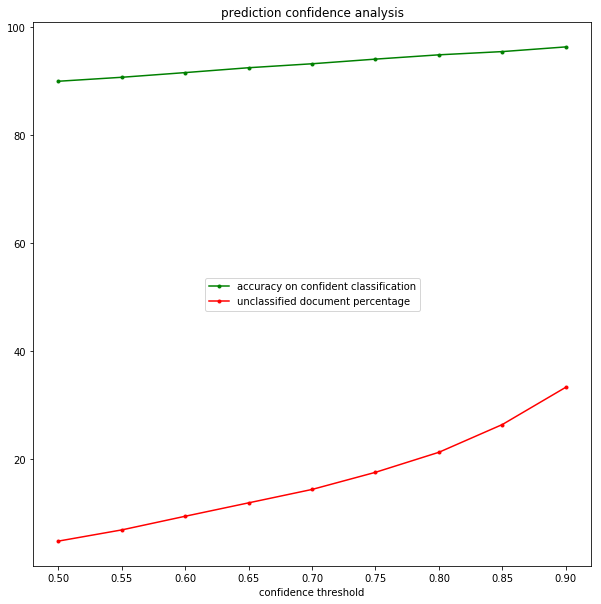

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

print (unclassified_perc)
print (true_confident_classification_perc)

plt.figure(figsize=(10,10))

plt.plot(confidence_threshold_span, true_confident_classification_perc,  '.-', label = 'accuracy on confident classification', color='green')
plt.plot(confidence_threshold_span, unclassified_perc, '.-',label = 'unclassified document percentage', color='red')
# Add titles
plt.title("prediction confidence analysis")
plt.xlabel("confidence threshold")
# Add legend
plt.legend(loc='center')

